In [270]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

In [180]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [255]:
train = pd.read_csv("train.csv")

train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [256]:
personalitymap = {'Extrovert': 1, 'Introvert': 0}
y = train['Personality'].map(personalitymap)
X = train.drop(columns=['id', 'Personality'])


X.isna().sum()

Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
dtype: int64

In [254]:
def apply_mappings(df):
    df = df.copy()
    df['Stage_fear'] = df['Stage_fear'].map({'Yes': 1, 'No': 0})
    df['Drained_after_socializing'] = df['Drained_after_socializing'].map({'Yes': 1, 'No': 0})
    return df

mapping_transformer = FunctionTransformer(apply_mappings)

pipeline = Pipeline([
    ('map', mapping_transformer),
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
])

pipeline

Pipeline(steps=[('map',
                 FunctionTransformer(func=<function apply_mappings at 0x00000295CC05ADE0>)),
                ('impute', SimpleImputer()), ('scale', StandardScaler())])

In [259]:
x_pipe = pipeline.fit_transform(X)

x_pipe.shape

(18524, 7)

In [260]:
x_train, x_val, y_train, y_val = train_test_split(x_pipe, y, test_size=0.2, random_state=42)

In [ ]:
class dataset(Dataset):

    def __init__(self, X, y = None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [271]:
training_data = dataset(x_train, y_train)
validation_data = dataset(x_val, y_val)

train_dataloader = DataLoader(training_data, batch_size=10, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=10, shuffle=True)

In [356]:
class MyModel(nn.Module):

    def __init__(self, input_dim):
        super(MyModel, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
            )

    def forward(self, x):
        return self.net(x)

In [357]:
input_dim = x_train.shape[1]  # Number of features
model = MyModel(input_dim).to(device)

In [358]:
summary(model)

Layer (type:depth-idx)                   Param #
MyModel                                  --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,024
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       8,256
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       2,080
│    └─LeakyReLU: 2-7                    --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       33
│    └─Sigmoid: 2-10                     --
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0

In [359]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [360]:
total_loss_train_plot = []
total_acc_train_plot = []

epochs = 20
for epoch in range(epochs):
    total_loss_train = 0
    total_acc_train = 0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x).squeeze(1)
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()

        # Compute batch accuracy
        preds = (y_pred > 0.5).float()
        correct = (preds == y).sum().item()
        acc = correct / len(y)
        total_acc_train += acc

    # Store epoch metrics
    total_loss_train_plot.append(total_loss_train / len(train_dataloader))
    total_acc_train_plot.append(total_acc_train / len(train_dataloader))

    print(f"Epoch {epoch+1}: loss = {total_loss_train_plot[-1]:.4f}, acc = {total_acc_train_plot[-1]:.4f}")


Epoch 1: loss = 0.1533, acc = 0.9660
Epoch 2: loss = 0.1410, acc = 0.9692
Epoch 3: loss = 0.1383, acc = 0.9688
Epoch 4: loss = 0.1382, acc = 0.9692
Epoch 5: loss = 0.1385, acc = 0.9692
Epoch 6: loss = 0.1364, acc = 0.9696
Epoch 7: loss = 0.1349, acc = 0.9692
Epoch 8: loss = 0.1354, acc = 0.9695
Epoch 9: loss = 0.1355, acc = 0.9695
Epoch 10: loss = 0.1350, acc = 0.9697
Epoch 11: loss = 0.1332, acc = 0.9696
Epoch 12: loss = 0.1329, acc = 0.9694
Epoch 13: loss = 0.1345, acc = 0.9696
Epoch 14: loss = 0.1338, acc = 0.9696
Epoch 15: loss = 0.1328, acc = 0.9696
Epoch 16: loss = 0.1336, acc = 0.9696
Epoch 17: loss = 0.1319, acc = 0.9694
Epoch 18: loss = 0.1314, acc = 0.9697
Epoch 19: loss = 0.1328, acc = 0.9696
Epoch 20: loss = 0.1322, acc = 0.9697


In [361]:
model.eval

<bound method Module.eval of MyModel(
  (net): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)>

In [362]:
with torch.no_grad():

    all_preds = []
    all_targets = []

    for x, y in validation_dataloader:

        x.to(device)
        y.to(device)

        y_pred = model(x).squeeze(1)

        all_preds.append(y_pred)
        all_targets.append(y.cpu())

In [363]:
# Concatenate all batches into one tensor
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

class_preds = (all_preds > 0.5).int()

In [ ]:
y_trues = all_targets.numpy()
y_preds = class_preds.numpy()

In [365]:
y_preds.shape

(3705,)

0.9686909581646423


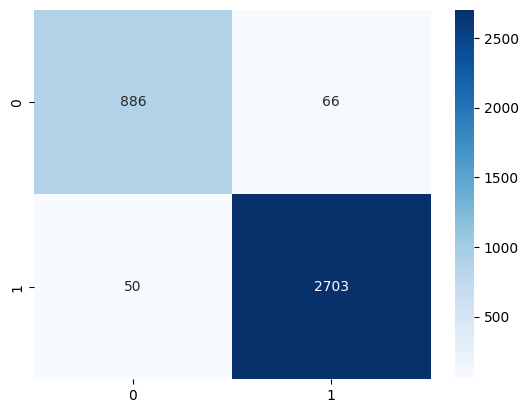

In [366]:
cm = confusion_matrix(y_trues, y_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

print(accuracy_score(y_trues, y_preds))

## Test Data

In [367]:
test = pd.read_csv("test.csv")

In [368]:
id_col = test['id']
test.drop(columns=['id'], inplace=True)

In [369]:
xr_test = pipeline.fit_transform(test)

In [370]:
xr_test.shape

(6175, 7)

In [371]:
x_train.shape

(14819, 7)

In [372]:
testing_datar = dataset(X = xr_test)

In [373]:
testr_dataloader = DataLoader(testing_datar, batch_size=10, shuffle=False)

In [374]:
with torch.no_grad():

    predsr = []

    for x in testr_dataloader:

        x = x.to(device)

        y_pred = model(x).squeeze(1)

        predsr.append(y_pred)

In [375]:
all_preds_y = torch.cat(predsr)

In [376]:
all_preds_y

tensor([0.9834, 0.0448, 0.9759,  ..., 0.9925, 0.9972, 0.0122])

In [377]:
zero_preds = (all_preds_y > 0.5).int()
zero_preds = zero_preds.numpy()

In [378]:
submission_df_nn = pd.DataFrame()

In [379]:
submission_df_nn['id'] = id_col
submission_df_nn['Personality'] = zero_preds

In [380]:
submission_df_nn

,id,Personality
0,18524,1
1,18525,0
2,18526,1
3,18527,1
4,18528,0
...,...,...
6170,24694,1
6171,24695,0
6172,24696,1
6173,24697,1


In [381]:
submission_df_nn['Personality'] = submission_df_nn['Personality'].map({0: 'Introvert', 1: 'Extrovert'})

In [382]:
submission_df_nn

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
...,...,...
6170,24694,Extrovert
6171,24695,Introvert
6172,24696,Extrovert
6173,24697,Extrovert


In [383]:
submission_df_nn.to_csv('submissions/submission_nn_bigger.csv', index=False)